In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from haversine import haversine, Unit
from scipy.spatial import cKDTree

dataset_path = "/Users/amirreisi/Documents/personal/snappfood project/final/raw-GM-.csv"
GMdata = pd.read_csv(dataset_path)
GMdata.head()
# Extracting lat o long 
def extract_lat_lon(url):
    pattern = r"!3d([-\d\.]+)!4d([-\d\.]+)"
    match = re.search(pattern, url)
    if match:
        return float(match.group(1)), float(match.group(2))
    return None, None

# Apply the function and create new columns
GMdata[['latitude', 'longitude']] = GMdata.apply(
    lambda row: pd.Series(extract_lat_lon(row['Link'])),
    axis=1
)
GMdata.head()

#Handling Duplicates
GMdata.drop_duplicates(inplace=True)

#REORDERING DataFrame
new_order = ['Name', 'Rating', 'Reviews', 'latitude', 'longitude','Link']
GM_df = GMdata[new_order]
# Making rate & Review Numeral
GMdata['Rating'] = pd.to_numeric(GMdata['Rating'], errors='coerce')
GMdata['Reviews'] = pd.to_numeric(GMdata['Reviews'], errors='coerce')
# Importing zoodex DataFrame
df1 = pd.read_csv('/Users/amirreisi/Documents/personal/snappfood project/final/restaurant_data_chunk_1.csv')
df2 = pd.read_csv('/Users/amirreisi/Documents/personal/snappfood project/final/restaurant_data_chunk_2.csv')
df3 = pd.read_csv('/Users/amirreisi/Documents/personal/snappfood project/final/restaurant_data_chunk_3.csv')
df4 = pd.read_csv('/Users/amirreisi/Documents/personal/snappfood project/final/restaurant_data_chunk_4.csv')
df5 = pd.read_csv('/Users/amirreisi/Documents/personal/snappfood project/final/restaurant_data_chunk_5.csv')
df6 = pd.read_csv('/Users/amirreisi/Documents/personal/snappfood project/final/restaurant_data_chunk_6.csv')
df7 = pd.read_csv('/Users/amirreisi/Documents/personal/snappfood project/final/restaurant_data_chunk_7.csv')
df8 = pd.read_csv('/Users/amirreisi/Documents/personal/snappfood project/final/restaurant_data_chunk_8.csv')
df9 = pd.read_csv('/Users/amirreisi/Documents/personal/snappfood project/final/restaurant_data_chunk_9.csv')
df10 = pd.read_csv('/Users/amirreisi/Documents/personal/snappfood project/final/restaurant_data_chunk_10.csv')
df11 = pd.read_csv('/Users/amirreisi/Documents/personal/snappfood project/final/restaurant_data_chunk_11.csv')
df12 = pd.read_csv('/Users/amirreisi/Documents/personal/snappfood project/final/restaurant_data_chunk_12.csv')
#Merge DataFrames
zoodex_data = pd.concat([df1, df2, df3,df5,df6,df7,df8,df9,df10,df11,df12])
# Removing Misvalues
zoodex_data['Number of Reviews'] = zoodex_data['Number of Reviews'].fillna('0')
zoodex_data = zoodex_data.dropna(subset=['Rating'])
# Making everything Numeric
zoodex_data['Rating'] = pd.to_numeric(zoodex_data['Rating'], errors='coerce')
zoodex_data['Number of Reviews'] = pd.to_numeric(zoodex_data['Number of Reviews'], errors='coerce')
# Extracting coordinates 
def extract_coordinates(url):
    parts = url.split('/dir//')[-1].split(',')
    if len(parts) >= 2:
        latitude = parts[0]
        longitude = parts[1]
        return latitude, longitude
    return None, None 
zoodex_data['Lat/Long'] = zoodex_data['Lat/Long URL'].apply(extract_coordinates)
#Removing unnecessary data
zoodex_data = zoodex_data.drop('Lat/Long URL', axis=1)
if not zoodex_data.empty and 'Lat/Long' in zoodex_data.columns:
    print("Data type of first entry in 'Lat/Long':", type(zoodex_data['Lat/Long'].iloc[0]))
else:
    print("DataFrame is empty or 'Lat/Long' column is missing.")
if not zoodex_data.empty:
    zoodex_data['latitude'] = zoodex_data['Lat/Long'].apply(lambda x: x[0] if isinstance(x, tuple) else None)
    zoodex_data['longitude'] = zoodex_data['Lat/Long'].apply(lambda x: x[1] if isinstance(x, tuple) else None)

    print(zoodex_data[['latitude', 'longitude']])
else:
    print("DataFrame is empty. No data to process.")

GMdata['latitude'] = pd.to_numeric(GMdata['latitude'], errors='coerce')
GMdata['longitude'] = pd.to_numeric(GMdata['longitude'], errors='coerce')
zoodex_data['latitude'] = pd.to_numeric(zoodex_data['latitude'], errors='coerce')
zoodex_data['longitude'] = pd.to_numeric(zoodex_data['longitude'], errors='coerce')
GMdata = GMdata.dropna(subset=['latitude', 'longitude'])
zoodex_data = zoodex_data.dropna(subset=['latitude', 'longitude'])
GMdata = GMdata[np.isfinite(GMdata['latitude']) & np.isfinite(GMdata['longitude'])]
zoodex_data = zoodex_data[np.isfinite(zoodex_data['latitude']) & np.isfinite(zoodex_data['longitude'])]
GMdata['latitude'] = pd.to_numeric(GMdata['latitude'], errors='coerce')
GMdata['longitude'] = pd.to_numeric(GMdata['longitude'], errors='coerce')
zoodex_data['latitude'] = pd.to_numeric(zoodex_data['latitude'], errors='coerce')
zoodex_data['longitude'] = pd.to_numeric(zoodex_data['longitude'], errors='coerce')

GMdata = GMdata.dropna(subset=['latitude', 'longitude'])
zoodex_data = zoodex_data.dropna(subset=['latitude', 'longitude'])

GMdata = GMdata[np.isfinite(GMdata['latitude']) & np.isfinite(GMdata['longitude'])]
zoodex_data = zoodex_data[np.isfinite(zoodex_data['latitude']) & np.isfinite(zoodex_data['longitude'])]
gm_coords = GMdata[['latitude', 'longitude']].to_numpy()
zoodex_coords = zoodex_data[['latitude', 'longitude']].to_numpy()
tree = cKDTree(gm_coords)
threshold = 0.001
results = tree.query_ball_point(zoodex_coords, r=threshold)
merged_data = []
non_matching_gm = []
non_matching_zoodex = []

# Merge matched data
for i, indices in enumerate(results):
    if indices:  
        for j in indices:
            gm_row = GMdata.iloc[j]
            zoodex_row = zoodex_data.iloc[i]
            
            merged_entry = {
                'name': gm_row['Name'], 
                'gm_rate': gm_row['Rating'],
                'gm_review': gm_row['Reviews'],
                'latitude': gm_row['latitude'],
                'longitude': gm_row['longitude'],
                'zoodex_review': zoodex_row['Number of Reviews'],
                'zoodex_rating': zoodex_row['Rating']
            }
            merged_data.append(merged_entry)

    else: 
        non_matching_zoodex.append(zoodex_data.iloc[i])

for idx in range(len(GMdata)):
    if not any(idx in indices for indices in results):
        non_matching_gm.append(GMdata.iloc[idx])

merged_df = pd.DataFrame(merged_data)
non_matching_gm_df = pd.DataFrame(non_matching_gm)

if 'Name' in non_matching_gm_df.columns:
    non_matching_gm_df['name'] = non_matching_gm_df['Name']
else:
    print("The 'Name' column does not exist in non_matching_gm_df")
non_matching_gm_df = non_matching_gm_df[['name', 'Rating', 'Reviews', 'latitude', 'longitude']]

# Handle non-matching Zoodex data
non_matching_zoodex_df = pd.DataFrame(non_matching_zoodex)

# Assign the 'Restaurant Name' column to 'name' in non-matching Zoodex data
non_matching_zoodex_df['name'] = non_matching_zoodex_df['Restaurant Name']
non_matching_zoodex_df = non_matching_zoodex_df[['name', 'Rating', 'Number of Reviews', 'latitude', 'longitude']]

non_matching_gm_df['zoodex_review'] = np.nan
non_matching_gm_df['zoodex_rating'] = np.nan
non_matching_zoodex_df['gm_rate'] = np.nan
non_matching_zoodex_df['gm_review'] = np.nan
# Combine all the data
all_data = pd.concat([merged_df, non_matching_gm_df, non_matching_zoodex_df], ignore_index=True)
final_merged_df = all_data
final_merged_df.to_csv('final_merged_restaurants.csv', index=False)
final = final_merged_df
final.head()
#Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
numerical_cols = ['gm_rate', 'gm_review', 'zoodex_review', 'zoodex_rating']
final= final.fillna(0)
final[numerical_cols] = scaler.fit_transform(final[numerical_cols])
final.head()


Data type of first entry in 'Lat/Long': <class 'tuple'>
              latitude           longitude
0   30.394922978970317   56.00576400264472
0            30.422326           55.977616
1            30.425637           55.975417
2            30.401899           55.986203
3   30.395472260001643  55.994920604114256
..                 ...                 ...
9            30.398197           55.982148
0            30.398643           55.991407
1            30.403926           55.997480
2   30.384212980978205   56.00835186744693
3   30.392073874782096   56.01147975064442

[95 rows x 2 columns]


,name,gm_rate,gm_review,latitude,longitude,zoodex_review,zoodex_rating,Rating,Reviews,Number of Reviews
0,زرین مشرق زمین,0.8,0.247525,30.394998,56.005679,0.014493,0.0,0.0,0.0,0.0
1,Olca doner اُلکا دونر,1.0,0.029703,30.395192,56.005448,0.014493,0.0,0.0,0.0,0.0
2,کافه رستوران سنتی بینام,0.0,0.000000,30.422523,55.977457,0.018116,0.0,0.0,0.0,0.0
3,Desert nights Restaurant,0.9,0.019802,30.401835,55.986047,1.000000,0.8,0.0,0.0,0.0
4,Cafepizza ghorob,0.0,0.000000,30.402473,55.986595,1.000000,0.8,0.0,0.0,0.0


In [2]:
final = final[['name', 'gm_rate', 'zoodex_rating', 'zoodex_review', 'gm_review']]
final.head()

,name,gm_rate,zoodex_rating,zoodex_review,gm_review
0,زرین مشرق زمین,0.8,0.0,0.014493,0.247525
1,Olca doner اُلکا دونر,1.0,0.0,0.014493,0.029703
2,کافه رستوران سنتی بینام,0.0,0.0,0.018116,0.000000
3,Desert nights Restaurant,0.9,0.8,1.000000,0.019802
4,Cafepizza ghorob,0.0,0.8,1.000000,0.000000


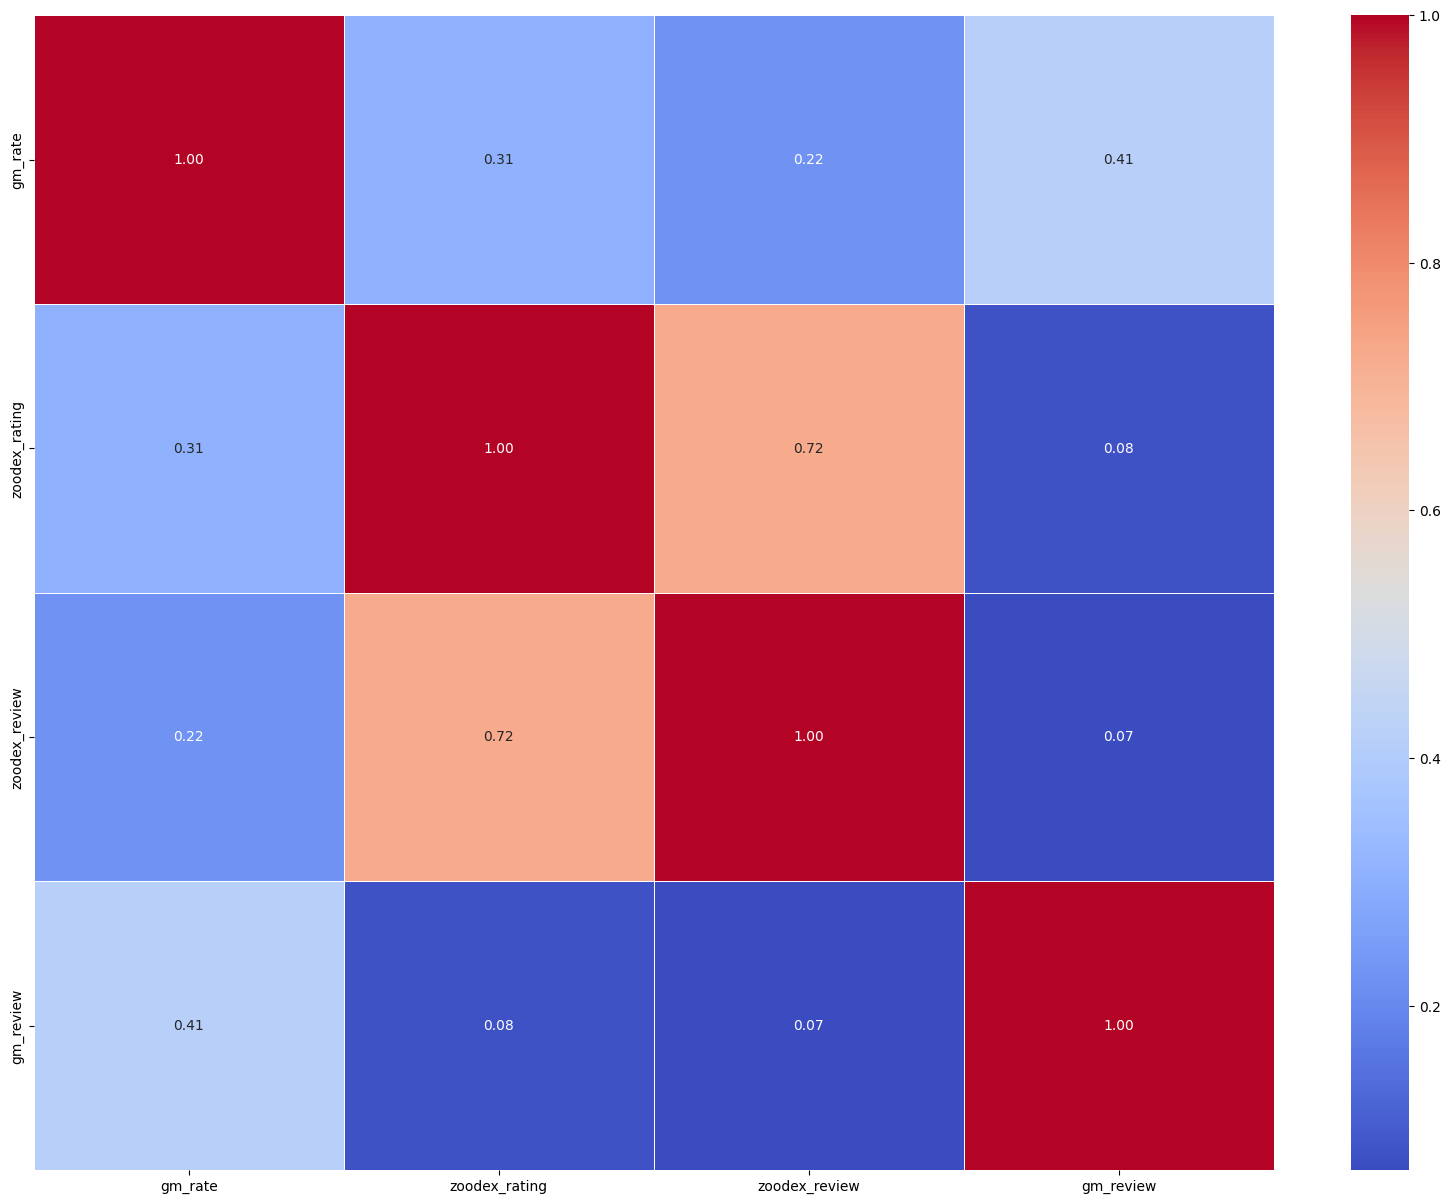

In [3]:
corr_data = final[['gm_rate', 'zoodex_rating', 'zoodex_review', 'gm_review']]
correlation_matrix = corr_data.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()


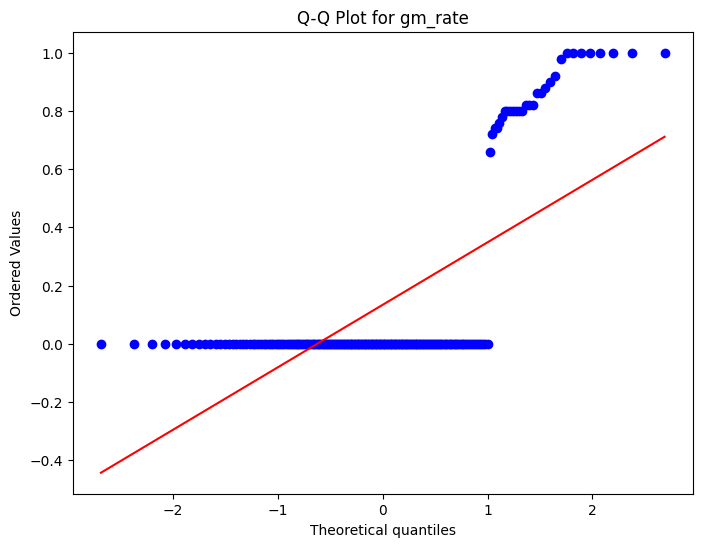

In [4]:
plt.figure(figsize=(8, 6))
stats.probplot(final['gm_rate'], dist="norm", plot=plt)
plt.title('Q-Q Plot for gm_rate')
plt.show()

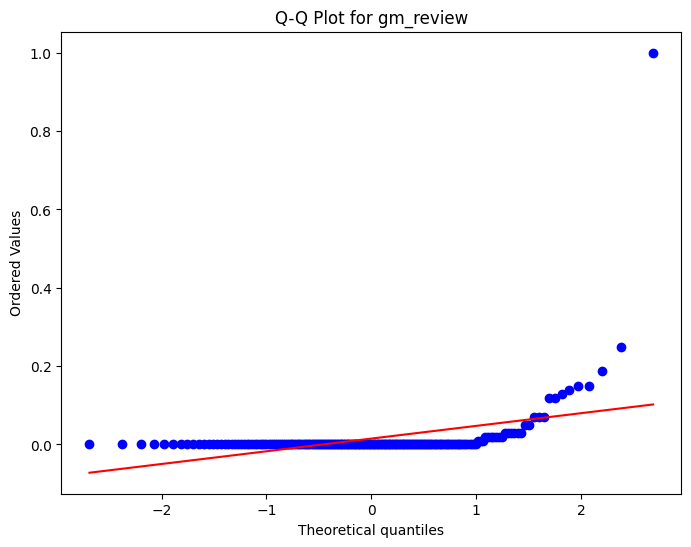

In [5]:
plt.figure(figsize=(8, 6))
stats.probplot(final['gm_review'], dist="norm", plot=plt)
plt.title('Q-Q Plot for gm_review')
plt.show()

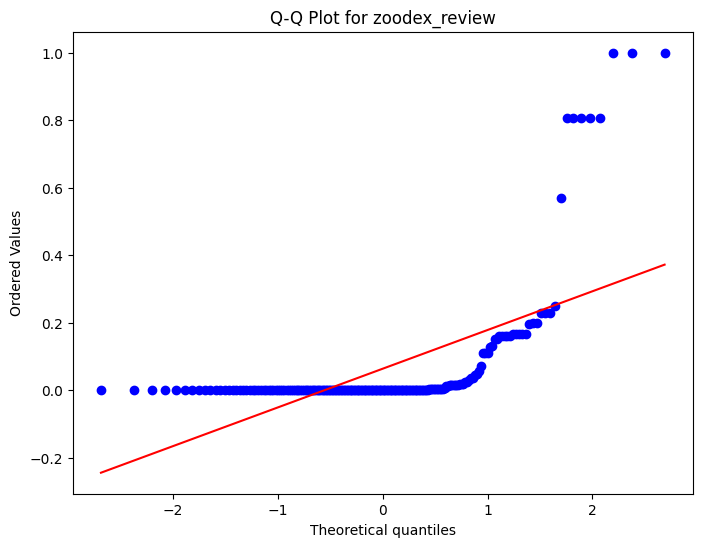

In [6]:
plt.figure(figsize=(8, 6))
stats.probplot(final['zoodex_review'], dist="norm", plot=plt)
plt.title('Q-Q Plot for zoodex_review')
plt.show()

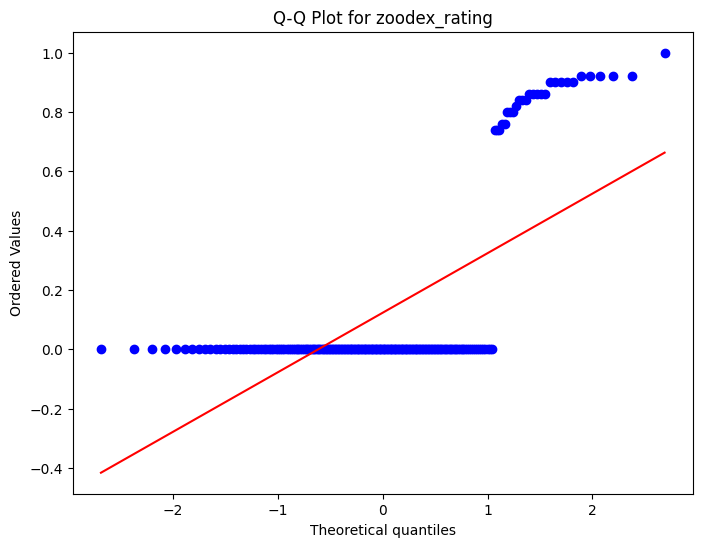

In [7]:
plt.figure(figsize=(8, 6))
stats.probplot(final['zoodex_rating'], dist="norm", plot=plt)
plt.title('Q-Q Plot for zoodex_rating')
plt.show()

In [8]:
#boxplot
#is this q-q okay? standarize

In [9]:
final.head()

,name,gm_rate,zoodex_rating,zoodex_review,gm_review
0,زرین مشرق زمین,0.8,0.0,0.014493,0.247525
1,Olca doner اُلکا دونر,1.0,0.0,0.014493,0.029703
2,کافه رستوران سنتی بینام,0.0,0.0,0.018116,0.000000
3,Desert nights Restaurant,0.9,0.8,1.000000,0.019802
4,Cafepizza ghorob,0.0,0.8,1.000000,0.000000


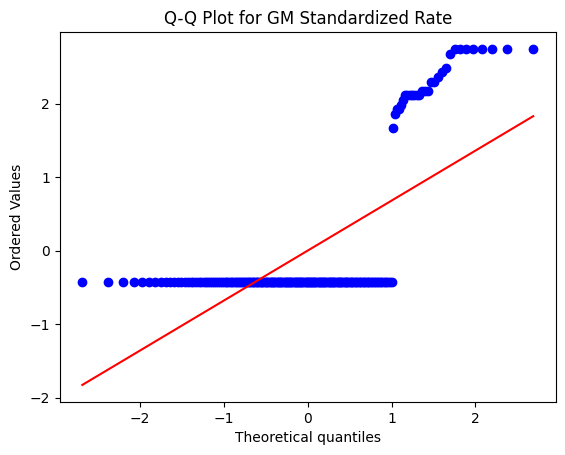

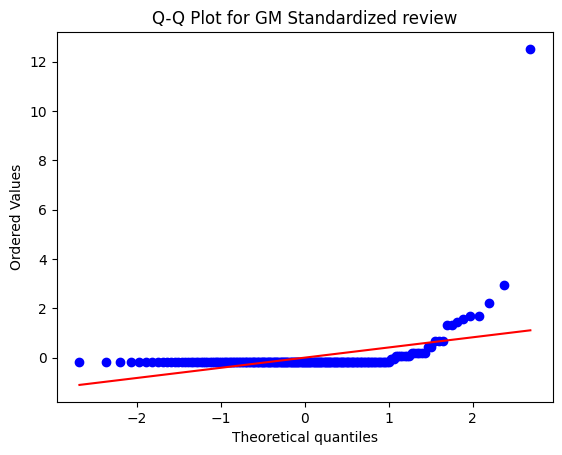

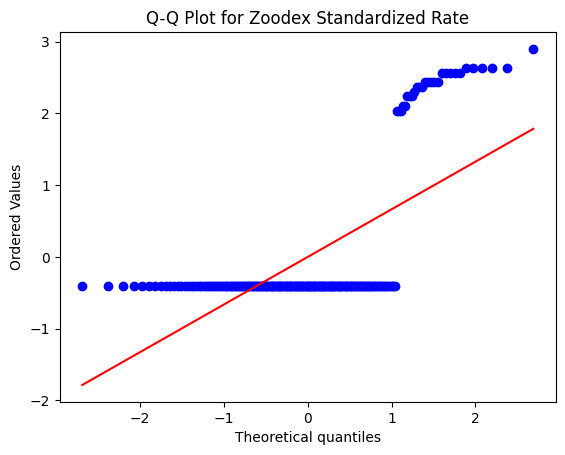

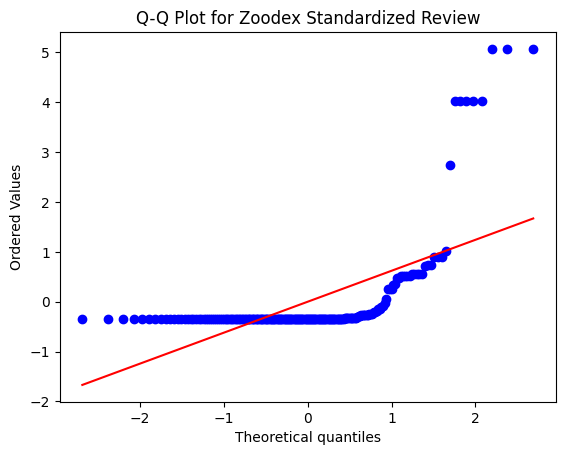

In [13]:
GM_Rating_Standardized = (final['gm_rate'] - final['gm_rate'].mean()) / final['gm_rate'].std()
GM_Reviews_Standardized = (final['gm_review'] - final['gm_review'].mean()) / final['gm_review'].std()
stats.probplot(GM_Rating_Standardized, dist="norm", plot=plt)
plt.title('Q-Q Plot for GM Standardized Rate')
plt.show()
stats.probplot(GM_Reviews_Standardized, dist="norm", plot=plt)
plt.title('Q-Q Plot for GM Standardized review')
plt.show()
Zoodex_Rating_Standardized = (final['zoodex_rating'] - final['zoodex_rating'].mean()) / final['zoodex_rating'].std()
stats.probplot(Zoodex_Rating_Standardized, dist="norm", plot=plt)
plt.title('Q-Q Plot for Zoodex Standardized Rate')
plt.show()
zoodex_review_Standardized = (final['zoodex_review'] - final['zoodex_review'].mean()) / final['zoodex_review'].std()
stats.probplot(zoodex_review_Standardized, dist="norm", plot=plt)
plt.title('Q-Q Plot for Zoodex Standardized Review')
plt.show()


In [14]:
final.head()

,name,gm_rate,zoodex_rating,zoodex_review,gm_review
0,زرین مشرق زمین,0.8,0.0,0.014493,0.247525
1,Olca doner اُلکا دونر,1.0,0.0,0.014493,0.029703
2,کافه رستوران سنتی بینام,0.0,0.0,0.018116,0.000000
3,Desert nights Restaurant,0.9,0.8,1.000000,0.019802
4,Cafepizza ghorob,0.0,0.8,1.000000,0.000000


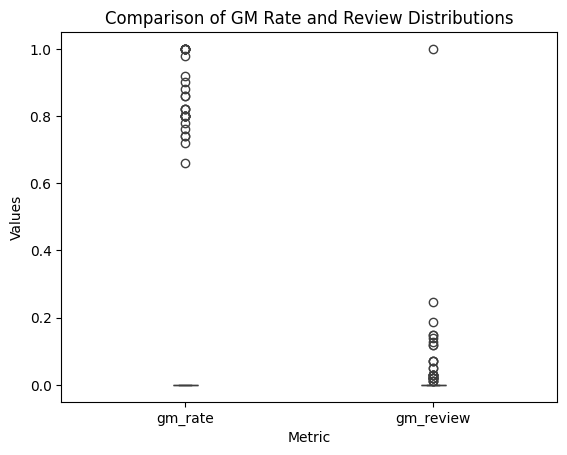

In [12]:
data_long = pd.melt(final, id_vars=['name'], value_vars=['gm_rate', 'gm_review'], var_name='Metric', value_name='Value')
sns.boxplot(x='Metric', y='Value', data=data_long, width=0.1)
plt.title('Comparison of GM Rate and Review Distributions')
plt.xlabel('Metric')
plt.ylabel('Values')
plt.show()